# Fit Spikes of HH with AdEx

In [1]:
from brian2 import *
from brian2modelfitting import *

INFO       Cache size for target "cython": 1046 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/alteska/.cython/brian_extensions" directory. [brian2]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyte

## HH

In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [4]:
tau = 0.1*ms

In [5]:
# The model
eqsHH = Equations('''
dnoise/dt = -noise/tau + tau**-0.5*xi : 1
I = noise * 5*nA: amp

dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [6]:
G = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
               )
G.v = El

G.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(G)
mon = StateMonitor(G, ['v', 'I'], record=0)

run(2000*ms)


INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.16s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


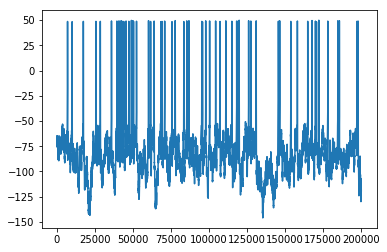

In [7]:
voltage = mon.v[0]/mV
plot(voltage);

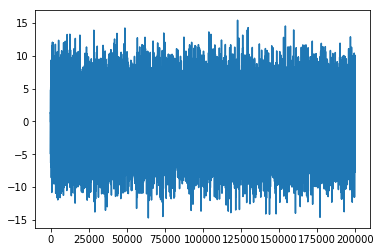

In [8]:
inp_cur = mon.I[0]/nA
plot(inp_cur);

In [9]:
out_spikes = [spike_mon.spike_trains()[0]/ms]
out_spikes

[array([  69.63,   99.66,  173.4 ,  256.18,  284.92,  358.32,  394.04,
         407.58,  421.49,  428.69,  439.01,  454.19,  472.21,  489.25,
         498.01,  503.18,  522.8 ,  601.83,  615.42,  638.68,  682.7 ,
         690.29,  707.86,  755.97,  777.23,  833.46,  852.94,  867.26,
         951.65,  956.31,  977.5 , 1003.19, 1042.71, 1071.61, 1109.83,
        1149.39, 1180.99, 1190.03, 1197.38, 1259.54, 1273.84, 1309.23,
        1455.15, 1463.56, 1536.59, 1579.94, 1647.84, 1676.11, 1698.58,
        1705.42, 1720.72, 1779.64, 1845.34, 1855.81, 1970.76, 1978.89])]

## AdEx

In [10]:
start_scope()

In [11]:
# Parameters
C = 171 * pF
# gL = 60 * nS
gL = 6.16243899e-08*siemens
taum = C / gL
EL = -65 * mV
VT = -50.4 * mV
DeltaT = 5 * mV
Vcut = VT + 50 * DeltaT

In [12]:
taum

2.77487534 * msecond

In [13]:
# Pick an electrophysiological behaviour
tauw, a, b, Vr = 124*ms, 4*nS, 0.0805*nA, -70.6*mV # Regular spiking (as in the paper)


In [14]:
eqs = """
dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I(t) - w)/C : volt
dw/dt = (a*(vm - EL) - w)/tauw : amp
"""

In [15]:
I = TimedArray(inp_cur*nA, dt=dt)

In [16]:
neuron = NeuronGroup(1, model=eqs, threshold='vm>Vcut',
                     reset="vm=Vr; w+=b", method='exponential_euler')
neuron.vm = EL
trace = StateMonitor(neuron, 'vm', record=0)
spike_mon = SpikeMonitor(neuron)

In [17]:
run(30*ms)

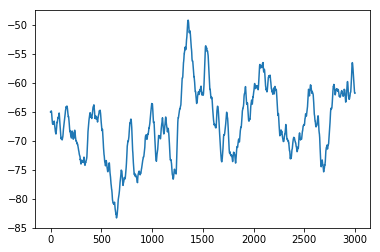

In [18]:
plot(trace.vm.transpose()/mV);

## Model Fitting

In [19]:
eqs = Equations(
"""
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + I*k - w)/C : volt
dw/dt = (a*(v - EL) - w)/tauw : amp
Vcut = VT + 50 * DeltaT : volt
taum = C / gL : second
gL: siemens (constant)
a : siemens (constant)
b : amp (constant)
VT : volt (constant)
DeltaT : volt (constant)
Vr : volt (constant)
k : 1 (constant)
C : farad (constant)
tauw : second (constant)
""", 
# EL : volt (constant)
# C: farad (constant)
# gL = 60 * nS,
# VT = -50.4 * mV,
# DeltaT = 5 * mV,    
# a = 4*nS,
# b = 0.0805*nA,
# Vr = -70.6*mV
# C = 171 * pF,
# tauw = 144*ms,
EL = -65 * mV,
)

In [20]:
n_opt = NevergradOptimizer()
metric = GammaFactor(time=300*ms, delta=300*ms)

In [21]:
# pass parameters to the NeuronGroup
fitter = SpikeFitter(model=eqs, input_var='I', dt=dt,
                     input=[inp_cur] * nA, output=out_spikes,
                     n_samples=60,
                     threshold='v>Vcut',
                     reset="v=Vr; w+=b",
                     refractory=1.41*ms,
                     param_init={'v': -65*mV},
                     )

SyntaxError: invalid syntax (<ipython-input-21-736574bce386>, line 8)

In [ ]:
result_dict, error = fitter.fit(n_rounds=10,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                gL=[30*nS, 60*nS],
                                a = [0, 20]*nS,
                                b = [0, 2]*nA,
                                VT = [-90, -10] * mV,
                                DeltaT = [5, 8] * mV,    
                                Vr = [-90, -30]*mV,
                                k = [0.01, 2],
                                C = [170, 200] * pF,
                                tauw = [0.1, 500]*ms,
                               )

In [ ]:
result_dict

In [ ]:
error

In [ ]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
print('spike times:', spikes)

In [ ]:
fits = fitter.generate(params=None, output_var='v',)

In [ ]:
# Vizualize the resutls
plot(fits[0][:10000]/mV)
plot(voltage[:10000]);
plt.show()

In [ ]:
# Vizualize the resutls
plot(fits[0]/mV)
plot(voltage);
plt.show()

In [ ]:
np.array(spikes)

In [ ]:
np.array(out_spikes)/0.01

In [ ]:
spikes[0][0]

In [ ]:
rcParams["scatter.marker"] = "|"

In [ ]:
plt.figure(figsize=(10,5))
scatter(out_spikes[0], np.ones_like(out_spikes[0]));
scatter(spikes[0], np.ones_like(spikes[0]));

In [ ]:
plt.figure(figsize=(10,5))
d = 10
scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
scatter(spikes[0][:d], np.ones_like(spikes[0][:d]));

In [ ]:
plot(spikes[0])